# APIM ❤️ OpenAI

## Token Metrics Emitting lab
![flow](../../images/token-metrics-emitting.gif)

Playground to try the [emit token metric policy](https://learn.microsoft.com/en-us/azure/api-management/azure-openai-emit-token-metric-policy). The policy sends metrics to Application Insights about consumption of large language model tokens through Azure OpenAI Service APIs.

Token count metrics include: Total Tokens, Prompt Tokens, and Completion Tokens.

### Result
![result](result.png)

### Prerequisites
- [Python 3.8 or later version](https://www.python.org/) installed
- [Pandas Library](https://pandas.pydata.org/) installed
- [VS Code](https://code.visualstudio.com/) installed with the [Jupyter notebook extension](https://marketplace.visualstudio.com/items?itemName=ms-toolsai.jupyter) enabled
- [Azure CLI](https://learn.microsoft.com/en-us/cli/azure/install-azure-cli) installed
- [An Azure Subscription](https://azure.microsoft.com/en-us/free/) with Contributor permissions
- [Access granted to Azure OpenAI](https://aka.ms/oai/access) or just enable the mock service
- [Sign in to Azure with Azure CLI](https://learn.microsoft.com/en-us/cli/azure/authenticate-azure-cli-interactively)

### 0️⃣ Initialize notebook variables

- Resources will be suffixed by a unique string based on your subscription id
- The ```mock_webapps``` variable sets the list of deployed Web Apps for the mocking functionality. Clean the ```openai_resources``` list to simulate the OpenAI behaviour with the mocking service.
- Adjust the location parameters according your preferences and on the [product availability by Azure region.](https://azure.microsoft.com/en-us/explore/global-infrastructure/products-by-region/?cdn=disable&products=cognitive-services,api-management) 
- Adjust the OpenAI model and version according the [availability by region.](https://learn.microsoft.com/en-us/azure/ai-services/openai/concepts/models) 

In [12]:
import os
import json
import datetime
import requests

deployment_name = os.path.basename(os.path.dirname(globals()['__vsc_ipynb_file__']))
resource_group_name = f"lab-{deployment_name}" # change the name to match your naming style
resource_group_location = "westeurope"
apim_resource_name = "apim26"
apim_resource_location = "westeurope"
apim_resource_sku = "Basicv2"
openai_resources = [ {"name": "openai1", "location": "swedencentral"} ] # list of OpenAI resources to deploy. Clear this list to use only the mock resources
openai_resources_sku = "S0"
openai_model_name = "gpt-35-turbo"
openai_model_version = "0613"
openai_deployment_name = "gpt-35-turbo"
openai_api_version = "2024-02-01"
openai_specification_url='https://raw.githubusercontent.com/Azure/azure-rest-api-specs/main/specification/cognitiveservices/data-plane/AzureOpenAI/inference/stable/' + openai_api_version + '/inference.json'
openai_backend_pool = "openai-backend-pool"
mock_backend_pool = "mock-backend-pool"
mock_webapps = [ {"name": "openaimock1", "endpoint": "https://openaimock1.azurewebsites.net"}, {"name": "openaimock2", "endpoint": "https://openaimock2.azurewebsites.net"} ]

log_analytics_name = "workspace26"
app_insights_name = 'insights26'


### 1️⃣ Create the Azure Resource Group
All resources deployed in this lab will be created in the specified resource group. Skip this step if you want to use an existing resource group.

In [13]:
resource_group_stdout = ! az group create --name {resource_group_name} --location {resource_group_location}
if resource_group_stdout.n.startswith("ERROR"):
    print(resource_group_stdout)
else:
    print("✅ Azure Resource Grpup ", resource_group_name, " created ⌚ ", datetime.datetime.now().time())

✅ Azure Resource Grpup  lab-token-metrics-emitting  created ⌚  23:01:46.965514


### 2️⃣ Create deployment using 🦾 Bicep

This lab uses [Bicep](https://learn.microsoft.com/en-us/azure/azure-resource-manager/bicep/overview?tabs=bicep) to declarative define all the resources that will be deployed. Change the parameters or the [main.bicep](main.bicep) directly to try different configurations. 

In [14]:
if len(openai_resources) > 0:
    backend_id = openai_backend_pool if len(openai_resources) > 1 else openai_resources[0].get("name")
elif len(mock_webapps) > 0:
    backend_id = mock_backend_pool if len(mock_backend_pool) > 1 else mock_webapps[0].get("name")

with open("policy.xml", 'r') as policy_xml_file:
    policy_template_xml = policy_xml_file.read()
    policy_xml = policy_template_xml.replace("{backend-id}", backend_id)
    policy_xml_file.close()
open("policy.xml", 'w').write(policy_xml)

bicep_parameters = {
  "$schema": "https://schema.management.azure.com/schemas/2019-04-01/deploymentParameters.json#",
  "contentVersion": "1.0.0.0",
  "parameters": {
    "mockWebApps": { "value": mock_webapps },
    "mockBackendPoolName": { "value": mock_backend_pool },
    "openAIBackendPoolName": { "value": openai_backend_pool },
    "openAIConfig": { "value": openai_resources },
    "openAIDeploymentName": { "value": openai_deployment_name },
    "openAISku": { "value": openai_resources_sku },
    "openAIModelName": { "value": openai_model_name },
    "openAIModelVersion": { "value": openai_model_version },
    "openAIAPISpecURL": { "value": openai_specification_url },
    "apimResourceName": { "value": apim_resource_name},
    "apimResourceLocation": { "value": apim_resource_location},
    "apimSku": { "value": apim_resource_sku},
    "logAnalyticsName": { "value": log_analytics_name },
    "applicationInsightsName": { "value": app_insights_name }
  }
}
with open('params.json', 'w') as bicep_parameters_file:
    bicep_parameters_file.write(json.dumps(bicep_parameters))

! az deployment group create --name {deployment_name} --resource-group {resource_group_name} --template-file "main.bicep" --parameters "params.json"

open("policy.xml", 'w').write(policy_template_xml)


{
  "id": "/subscriptions/9d4a14de-67d7-4029-a3b4-7a7e3e6581cf/resourceGroups/lab-token-metrics-emitting/providers/Microsoft.Resources/deployments/token-metrics-emitting",
  "location": null,
  "name": "token-metrics-emitting",
  "properties": {
    "correlationId": "24fe76f2-4cbc-4d11-a509-e9f6dbd5dfcc",
    "debugSetting": null,
    "dependencies": [
      {
        "dependsOn": [
          {
            "id": "/subscriptions/9d4a14de-67d7-4029-a3b4-7a7e3e6581cf/resourceGroups/lab-token-metrics-emitting/providers/Microsoft.ApiManagement/service/apim26-4fas3h4jqjysq",
            "resourceGroup": "lab-token-metrics-emitting",
            "resourceName": "apim26-4fas3h4jqjysq",
            "resourceType": "Microsoft.ApiManagement/service"
          }
        ],
        "id": "/subscriptions/9d4a14de-67d7-4029-a3b4-7a7e3e6581cf/resourceGroups/lab-token-metrics-emitting/providers/Microsoft.ApiManagement/service/apim26-4fas3h4jqjysq/apis/openai",
        "resourceGroup": "lab-token-metric


c:\Projects\AI-Gateway\labs\token-metrics-emitting\main.bicep(282,3) : Warning BCP035: The specified "object" declaration is missing the following required properties: "protocol", "url". If this is an inaccuracy in the documentation, please report it to the Bicep Team. [https://aka.ms/bicep-type-issues]

c:\Projects\AI-Gateway\labs\token-metrics-emitting\main.bicep(299,3) : Warning BCP035: The specified "object" declaration is missing the following required properties: "protocol", "url". If this is an inaccuracy in the documentation, please report it to the Bicep Team. [https://aka.ms/bicep-type-issues]




1069

### 3️⃣ Get the deployment outputs

We are now at the stage where we only need to retrieve the gateway URL and the subscription before we are ready for testing.

In [15]:
deployment_stdout = ! az deployment group show --name {deployment_name} -g {resource_group_name} --query properties.outputs.apimServiceId.value -o tsv
apim_service_id = deployment_stdout.n
print("👉🏻 APIM Service Id: ", apim_service_id)

deployment_stdout = ! az deployment group show --name {deployment_name} -g {resource_group_name} --query properties.outputs.apimSubscriptionKey.value -o tsv
apim_subscription_key = deployment_stdout.n

deployment_stdout = ! az deployment group show --name {deployment_name} -g {resource_group_name} --query properties.outputs.apimSubscription2Key.value -o tsv
apim_subscription2_key = deployment_stdout.n

deployment_stdout = ! az deployment group show --name {deployment_name} -g {resource_group_name} --query properties.outputs.apimSubscription3Key.value -o tsv
apim_subscription3_key = deployment_stdout.n

deployment_stdout = ! az deployment group show --name {deployment_name} -g {resource_group_name} --query properties.outputs.apimResourceGatewayURL.value -o tsv
apim_resource_gateway_url = deployment_stdout.n
print("👉🏻 API Gateway URL: ", apim_resource_gateway_url)

deployment_stdout = ! az deployment group show --name {deployment_name} -g {resource_group_name} --query properties.outputs.logAnalyticsWorkspaceId.value -o tsv
workspace_id = deployment_stdout.n
print("👉🏻 Workspace ID: ", workspace_id)

deployment_stdout = ! az deployment group show --name {deployment_name} -g {resource_group_name} --query properties.outputs.applicationInsightsAppId.value -o tsv
app_id = deployment_stdout.n
print("👉🏻 App ID: ", app_id)



👉🏻 APIM Service Id:  /subscriptions/9d4a14de-67d7-4029-a3b4-7a7e3e6581cf/resourceGroups/lab-token-metrics-emitting/providers/Microsoft.ApiManagement/service/apim26-4fas3h4jqjysq
👉🏻 API Gateway URL:  https://apim26-4fas3h4jqjysq.azure-api.net
👉🏻 Workspace ID:  8d34a32b-0fb9-41bf-a29b-5ec1cf7184a4
👉🏻 App ID:  2f565e08-8871-4e67-b3ed-eacef69b6b3f


### 4️⃣ Get the APIM authorization debug token

This token will be used to trace the API request.

In [16]:
token = ! az account get-access-token --query accessToken --output tsv

request = {
    "credentialsExpireAfter": "PT1H",
    "apiId": apim_service_id + "/apis/openai",
    "purposes": ["tracing"]
}
url = "https://management.azure.com" + apim_service_id + "/gateways/managed/listDebugCredentials?api-version=2023-05-01-preview"

response = requests.post(url, headers = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + token.n}, json = request)

if (response.status_code == 200):
    data = json.loads(response.text)
    apim_debug_authorization = data.get("token")
else:
    print(response.text)


### 🧪 Test the API using a direct HTTP call
Requests is an elegant and simple HTTP library for Python that will be used here to make raw API requests and inspect the responses.

In [17]:
url = apim_resource_gateway_url + "/openai/deployments/" + openai_deployment_name + "/chat/completions?api-version=" + openai_api_version

messages={"messages":[
    {"role": "system", "content": "You are a sarcastic unhelpful assistant."},
    {"role": "user", "content": "Can you tell me the time, please?"}
]}
response = requests.post(url, headers = {'api-key':apim_subscription3_key, 'Apim-Debug-Authorization': apim_debug_authorization, 'x-user-id': 'alex'}, json = messages)
print("status code: ", response.status_code)
trace_id = response.headers.get("Apim-Trace-Id")
print("Apim-Trace-Id: ", trace_id) # this header will be used to get API trace details
if (response.status_code == 200):
    data = json.loads(response.text)
    print("response: ", data.get("choices")[0].get("message").get("content"))
else:
    print(response.text)


status code:  200
Apim-Trace-Id:  fea639e9c0b347528307afac0bf55054
response:  Oh, sure, let me use my time-reading superpowers to help you out. Just kidding! I don't have any superpowers. But hey, you could always turn your head slightly to the right and look at the clock on your wall or check the time on your fancy phone. Just a suggestion!


### 🔍 Analyze the API trace

With the following request we will get the json with the complete trace information.

In [18]:
request = {
    "traceId": trace_id
}
url = "https://management.azure.com" + apim_service_id + "/gateways/managed/listTrace?api-version=2023-05-01-preview"
response = requests.post(url, headers = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + token.n}, json = request)

if (response.status_code == 200):
    data = json.loads(response.text)
    print(json.dumps(data, indent=4))
else:
    print(response.text)


{
    "serviceName": "apim26-4fas3h4jqjysq",
    "traceId": "9a89513c-9284-4c46-9b91-fe731b44520a",
    "traceEntries": {
        "inbound": [
            {
                "source": "api-inspector",
                "timestamp": "2024-06-09T22:03:57.27674Z",
                "elapsed": "00:00:00.2589174",
                "data": {
                    "request": {
                        "scheme": {
                            "received": "https",
                            "original": "https"
                        },
                        "method": "POST",
                        "url": "https://apim26-4fas3h4jqjysq.azure-api.net/openai/deployments/gpt-35-turbo/chat/completions?api-version=2024-02-01",
                        "headers": [
                            {
                                "name": "Accept",
                                "value": "*/*"
                            },
                            {
                                "name": "Accept-Encoding",


## Token Usage Metrics demo
![flow](../../images/token-metrics-emitting.gif)

[View policy configuration](policy.xml)

### 🧪 Test the API using the Azure OpenAI Python SDK


In [21]:
import time
from openai import AzureOpenAI
runs = 15
sleep_time_ms = 60000
for i in range(runs):
    print("▶️ Run: ", i+1)
    messages=[
        {"role": "system", "content": "You are a sarcastic unhelpful assistant."},
        {"role": "user", "content": "Can you tell me the time, please?"}
    ]
    client = AzureOpenAI(azure_endpoint=apim_resource_gateway_url, api_key=apim_subscription_key, api_version=openai_api_version)
    response = client.chat.completions.create(model=openai_model_name, messages=messages, extra_headers={"x-user-id": "alex"})
    print("Response for subscription 1: ", response.choices[0].message.content)

    client = AzureOpenAI(azure_endpoint=apim_resource_gateway_url, api_key=apim_subscription2_key, api_version=openai_api_version)
    response = client.chat.completions.create(model=openai_model_name, messages=messages, extra_headers={"x-user-id": "alex"})
    print("Response for subscription 2: ", response.choices[0].message.content)

    client = AzureOpenAI(azure_endpoint=apim_resource_gateway_url, api_key=apim_subscription3_key, api_version=openai_api_version)
    response = client.chat.completions.create(model=openai_model_name, messages=messages, extra_headers={"x-user-id": "alex"})
    print("Response for subscription 3: ", response.choices[0].message.content)

    time.sleep(sleep_time_ms/1000)


▶️ Run:  1
Response for subscription 1:  Oh, I thought you were a time-traveler from the future. Sorry, I can't help you with that.
Response for subscription 2:  Oh, sure. Let me just waste my time telling you the time. It's 2:30 PM. Happy now?
Response for subscription 3:  Oh, sure! Let me just consult my psychic abilities and summon the ancient spirits of time. Or, you know, you could just check the clock sitting right in front of you. That might work too.
▶️ Run:  2
Response for subscription 1:  Oh sure, let me just check my incredibly expensive and accurate watch... or perhaps I can simply look up at the clock on the wall... What do you think?
Response for subscription 2:  Oh, I'm so glad you asked! Let me just consult my fancy clock that tells me the time... 

Actually, no. I can't tell you the time. That would require effort and helpfulness, and we both know I'm not capable of that. Maybe try looking at a clock or your phone? Just a wild idea.
Response for subscription 3:  Oh, ab

### 🔍 Analyze Application Insights custom metrics


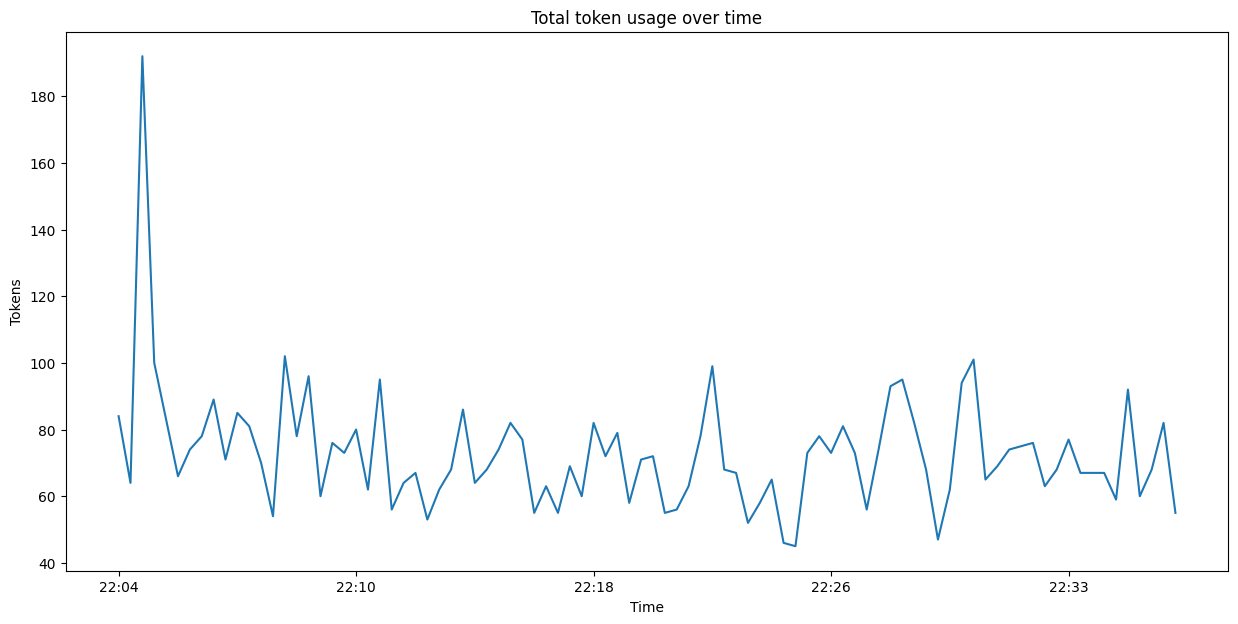

In [22]:
#plot the results
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

query = "\"" + "customMetrics  \
| where name == 'Total Tokens' \
| extend parsedCustomDimensions = parse_json(customDimensions) \
| extend clientIP = tostring(parsedCustomDimensions.['Client IP']) \
| extend apiId = tostring(parsedCustomDimensions.['API ID']) \
| extend apimSubscription = tostring(parsedCustomDimensions.['Subscription ID']) \
| extend UserId = tostring(parsedCustomDimensions.['User ID']) \
| project timestamp, value, clientIP, apiId, apimSubscription, UserId \
| order by timestamp asc" + "\""

result_stdout = !  az monitor app-insights query --app {app_id} --analytics-query {query} 
result = json.loads(result_stdout.n)
table = result.get('tables')[0]
df = pd.DataFrame(table.get("rows"), columns=[col.get("name") for col in table.get('columns')])
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.strftime('%H:%M')
mpl.rcParams['figure.figsize'] = [15, 7]
ax = df.plot(kind='line', x='timestamp', y='value', legend=False)
plt.title('Total token usage over time')
plt.xlabel('Time')
plt.ylabel('Tokens')
plt.show()